In [3]:
#import necessary libraries we wll use for fraud detection system
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
#from sklearn.svm import OneClassSvm
from pylab import rcParams
RANDOM_SPEED=42
LABELS = ["Normal", "Fraud"]

In [4]:
data = pd.read_csv('Fraud.csv')

In [5]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


#### Data cleaning including missing values, outliers and multicollinearity

In [7]:
data.isnull().values.any()

False

In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
## detect missing values in the given series object. 
## It return a boolean same-sized object indicating if the values are NA. 
## Missing values gets mapped to True and non-missing value gets mapped to False 

data.isna().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

In [10]:
data.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [11]:
data.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [12]:
data.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [13]:
#Here we will check which records hold value 1 for isFraud feature. This indicates that the given customer is a fraud person trying
#to perform transaction in a wrong way.
data_fraud = data.loc[data.isFraud == 1]
data_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [14]:
#The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200000 in a single transaction.

data_flggedfraud = data.loc[data.isFlaggedFraud == 1]
data_flggedfraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1


#### There are too much of outliers so we cannot impute them, instead we have to take outliers as our original data.

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

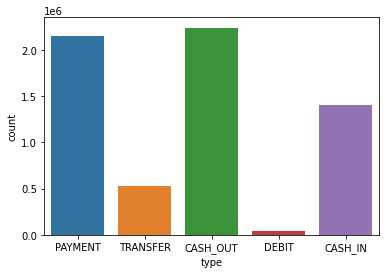

In [15]:
#for discrete data
sns.countplot(data.type)

## Exploratory Data Analysis (EDA for fraud detection system)

In [16]:
from pandas_profiling import ProfileReport

In [17]:
profile = ProfileReport(data,title="Pandas Profiling Report", minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
data.describe(include=['object'])

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


In [19]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [20]:
##converting categorical features to numerical

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
data.type = label.fit_transform(data.type)
data.nameOrig = label.fit_transform(data.nameOrig)
data.nameDest = label.fit_transform(data.nameDest)


C:\Users\hp\AppData\Local\Temp/ipykernel_14876/1928455986.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/1928455986.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/1928455986.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/1928455986.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/1928455986.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/1928455986.py:15: UserWarning: Matplotlib is cur

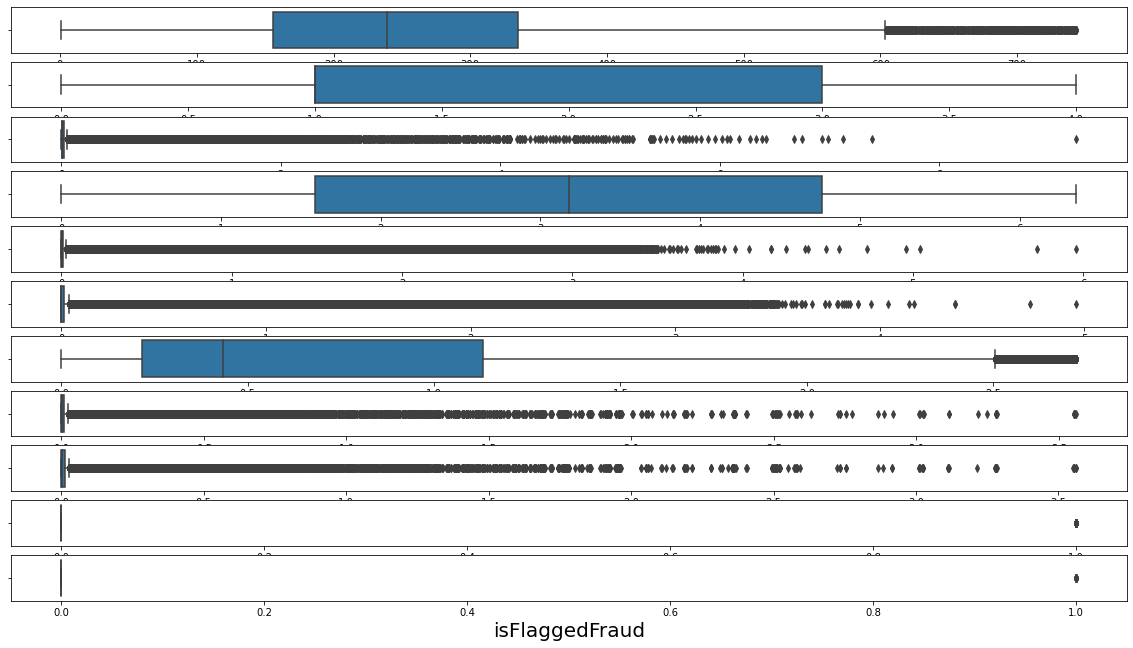

In [21]:
##checking for outliers
##We will use boxplot for this purpose
box_plot=data[['step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest',
               'newbalanceDest','isFraud','isFlaggedFraud']]
plt.figure(figsize=(20,20), facecolor='white')
plotno=1

for column in box_plot:
    if plotno<=20 :
        ax=plt.subplot(20, 1, plotno)
        sns.boxplot(x=box_plot[column])
        plt.xlabel(column, fontsize=20)
        
    plotno+=1
    plt.show()

In [22]:
#label encoding done successfully
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB


C:\Users\hp\AppData\Local\Temp/ipykernel_2848/643289372.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


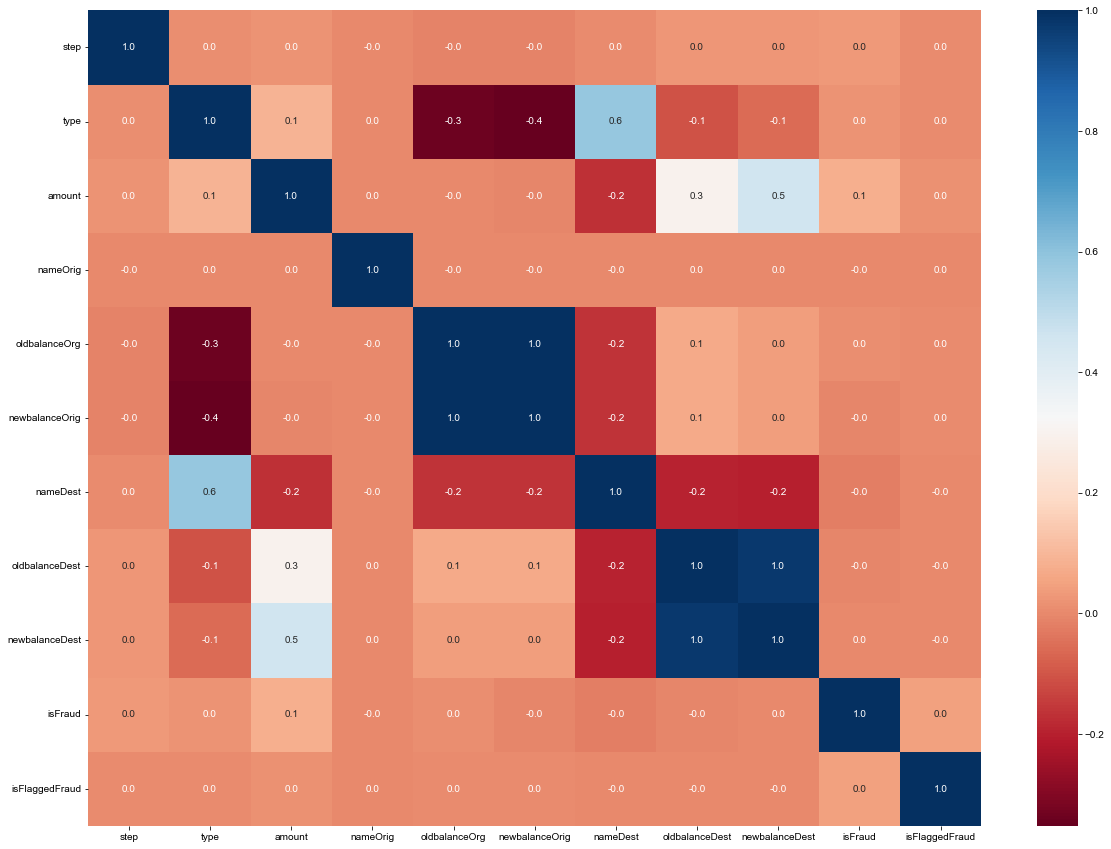

In [39]:
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True, fmt='.1f', cmap='RdBu')
sns.set(font_scale=2.25)
plt.show()

In [24]:
##displays the correlated data
corr_matrix=data.corr()
corr_matrix['isFlaggedFraud'].sort_values(ascending=True)

nameDest         -0.001122
newbalanceDest   -0.000529
oldbalanceDest   -0.000513
nameOrig          0.000667
type              0.002685
step              0.003277
newbalanceOrig    0.003776
oldbalanceOrg     0.003835
amount            0.012295
isFraud           0.044109
isFlaggedFraud    1.000000
Name: isFlaggedFraud, dtype: float64

### How did you select variables to be included in the model?

To select the variables in the model, we check for correlation between dependent variable with independent variable

### What are the key factors that predict fraudulent customers?
The variables we select should be dependent and independent variable. The dependent variable is generally an output variable 
like isfraud in this usecase because this is what the example about, we need to find if customer is fraud or not. So, our first variable is isFraud. The independent variable is what the output is dependent on. Here, to find a customer is fraud or not we will check for amount which withdrawn from account. If there is something in the amount figure, it should be highlighted 
to the company and make sure the account holder is aware about this suspicious transaction. Hence, our second variable i.e. 
independent variable should be amount.

### Do these factors make sense? If yes, How? If not, How not?

yes,they make sense, if the amount is more we can assume it may be fraud and if isfraud is 1, the chances of its isFlaggedFraud is more.

# Model Building

In [25]:
X = data.loc[:,['isFraud','amount','oldbalanceOrg','newbalanceOrig','step','type','nameOrig']]
y = data.isFlaggedFraud

In [26]:
X.head()

,isFraud,amount,oldbalanceOrg,newbalanceOrig,step,type,nameOrig
0,0,9839.64,170136.0,160296.36,1,3,757869
1,0,1864.28,21249.0,19384.72,1,3,2188998
2,1,181.00,181.0,0.00,1,4,1002156
3,1,181.00,181.0,0.00,1,1,5828262
4,0,11668.14,41554.0,29885.86,1,3,3445981


In [27]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: isFlaggedFraud, dtype: int64

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [89]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4453834, 7), (1908786, 7), (4453834,), (1908786,))

In [90]:
from scipy.stats import skew
from scipy.stats import kurtosis

isFraud
769.7023761366951


C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/975893154.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


amount
1797.9552914598337


C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/975893154.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


oldbalanceOrg
32.9648516960387


C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/975893154.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


newbalanceOrig
32.06695841776864


C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/975893154.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


step
0.3290693534211582


C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/975893154.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


type
-1.4345763413580779


C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/975893154.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


nameOrig
-1.2000279621839782


C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Local\Temp/ipykernel_14876/975893154.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


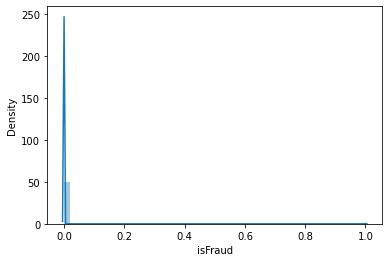

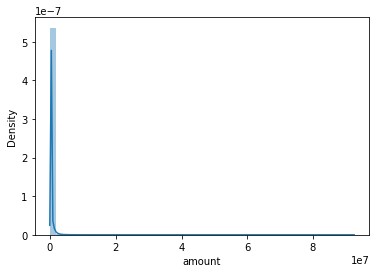

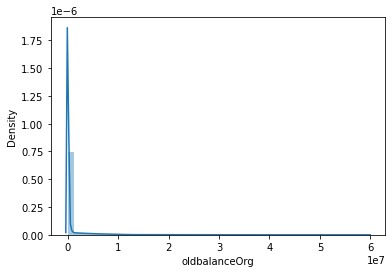

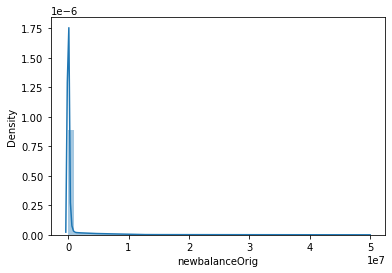

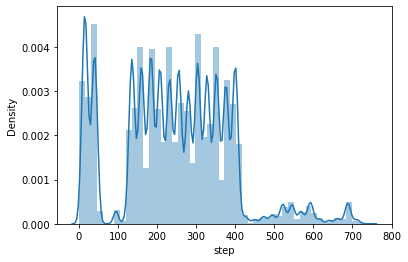

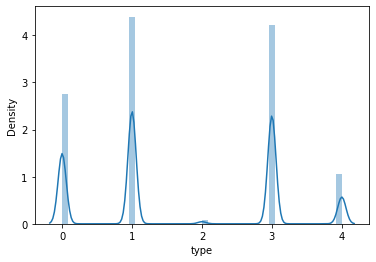

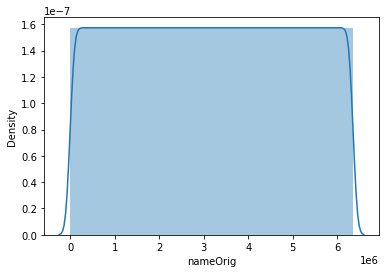

In [91]:
for col in X_train:
    print(col)
    print(kurtosis(data[col]))
    
    plt.figure()
    sns.distplot(data[col])
    plt.show()

In [93]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Describe your fraud detection model in elaboration

### DECISION TREE

In [94]:
from sklearn.tree import DecisionTreeRegressor

In [95]:
decision = DecisionTreeRegressor(max_depth=25)
decision.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=25)

In [96]:
decision.score(X_train, y_train)

1.0

In [97]:
decision.score(X_test, y_test)

0.7142846664954787

In [98]:
p_test = decision.predict(X_test)

In [99]:
def mae(p, t):
    return np.sum(np.abs(p - t)) / len(p)

In [100]:
mae(p_test, y_test)

1.0477863940745583e-06

In [101]:
def print_score(mm):
    print("train r^2: " + str(mm.score(X_train, y_train)))
    print("validation r^2: " + str(mm.score(X_test, y_test)))
    p_test = mm.predict(X_test)
    p_train = mm.predict(X_train)
    print("mean absolute error(Train): " + str(mae(p_train, y_train)))
    print("mean absolute error(Validation): " + str(mae(p_test, y_test)))
print_score(decision)

train r^2: 1.0
validation r^2: 0.7142846664954787
mean absolute error(Train): 0.0
mean absolute error(Validation): 1.0477863940745583e-06


In [102]:
p_test = decision.predict(X_test)

In [103]:
p_test

array([0., 0., 0., ..., 0., 0., 0.])

### What kind of prevention should be adopted while company update it's infrastructure
The company should collect customer's contact number for verification purpose. Also, before proceeding for further transaction,
the company should make sure of amount; the amount should not exceed a certain limit. If it does, it can be done with all permission of 
account holder.

### Assuming these all actions are implemented, how would you determine if they work?
We should always look up for a better and a more generalised model for the problem or a particular usecase. If this detection system
gets implemented, it will work better than previous or existing system